## Task Description




> Given images of different distribution,  labelled images (real world images) and unlabelled images (drawing images). 

> Use domain adaptation to predict the drawing images correctly.

> Dataset: 10 classes images.
- Real images: 5000 32x32x3 labelled images.
- Drawing images: 100000 28x28x1 gray scale unlabelled images.

## Packages

In [3]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function

import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset
import os
from tqdm import tqdm
import seaborn

In [ ]:
def same_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(123456)

## Import Data

In [ ]:
# Unzip the files
!unzip pic.zip

## Image Example

In [ ]:
def no_axis_show(img, title='', cmap=None):
  # imshow, and set the interpolation mode to be "nearest"。
  fig = plt.imshow(img, interpolation='nearest', cmap=cmap)
  # do not show the axes in the images.
  fig.axes.get_xaxis().set_visible(False)
  fig.axes.get_yaxis().set_visible(False)
  plt.title(title)


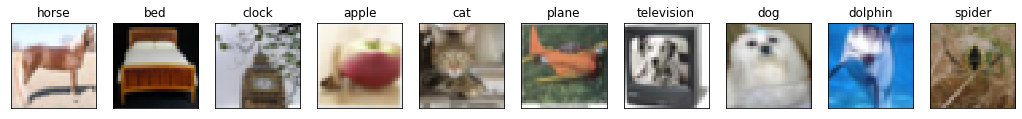

In [ ]:
# Real Images

titles = ['horse', 'bed', 'clock', 'apple', 'cat', 'plane', 'television', 'dog', 'dolphin', 'spider']
plt.figure(figsize=(18, 18))
for i in range(10):
  plt.subplot(1, 10, i+1)
  fig = no_axis_show(plt.imread(f'real_or_drawing/train_data/{i}/{500*i}.bmp'), title=titles[i])

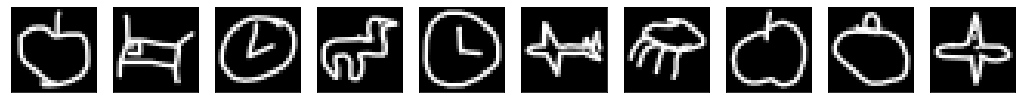

In [ ]:
# Drawings

plt.figure(figsize=(18, 18))
for i in range(10):
  plt.subplot(1, 10, i+1)
  fig = no_axis_show(plt.imread(f'real_or_drawing/test_data/0/' + str(i).rjust(5, '0') + '.bmp'))

## Load Dataset / Image Augmentation



### Canny Edge Detection


> Use edge DEtection to make real world images more like it from the same distribution of drawings.



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


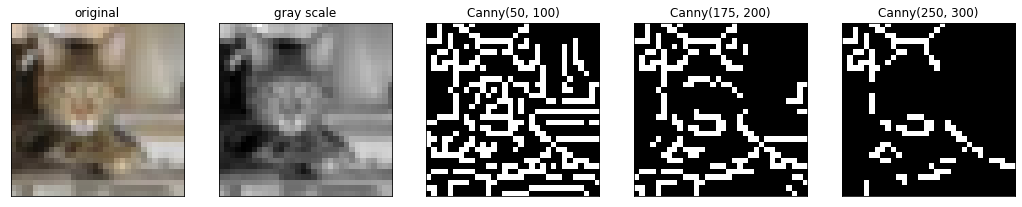

In [ ]:
# Plot edge detection images with different threshold

plt.figure(figsize=(18, 18))

# Original
original_img = plt.imread(f'real_or_drawing/train_data/4/2000.bmp')
plt.subplot(1, 5, 1)
no_axis_show(original_img, title='original')

# Gray Scale
gray_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)
plt.subplot(1, 5, 2)
no_axis_show(gray_img, title='gray scale', cmap='gray')

# Threshold (50,100)
canny_1 = cv2.Canny(gray_img, 50, 100)
plt.subplot(1, 5, 3)
no_axis_show(canny_1, title='Canny(50, 100)', cmap='gray')

# Threshold (175,200)
canny_2 = cv2.Canny(gray_img, 175, 200)
plt.subplot(1, 5, 4)
no_axis_show(canny_2, title='Canny(175, 200)', cmap='gray')

# Threshold (250,300)
canny_3 = cv2.Canny(gray_img, 250, 300)
plt.subplot(1, 5, 5)
no_axis_show(canny_3, title='Canny(250, 300)', cmap='gray')
  

### Data Process



In [ ]:

real_transform = transforms.Compose([
    # Transform image to grayscale. 
    transforms.Grayscale(),
    # Edge detection.
    transforms.Lambda(lambda x: cv2.Canny(np.array(x), 170, 300)),
    # Transform np.array back to the skimage.Image.
    transforms.ToPILImage(),
    # Horizontal Flip (p=0.5).
    transforms.RandomHorizontalFlip(),
    # Rotate (15 degree). 
    transforms.RandomRotation(15, fill=(0,)),
    # Transform to tensor for model inputs.
    transforms.ToTensor(),
    ])
draw_transform = transforms.Compose([
    # Transform image to grayscale.
    transforms.Grayscale(),
    # Resize images to 32x32.
    transforms.Resize((32, 32)),
    # Horizontal Flip (p=0.5).
    transforms.RandomHorizontalFlip(),
    # Rotate (15 degree). 
    transforms.RandomRotation(15, fill=(0,)),
    # Transform to tensor for model inputs.
    transforms.ToTensor(),
    ])

real_dataset = ImageFolder('real_or_drawing/train_data', transform=real_transform)
draw_dataset = ImageFolder('real_or_drawing/test_data', transform=draw_transform)


## Model


> Model Structure: DaNN(https://arxiv.org/pdf/1505.07818.pdf)




In [ ]:
class FeatureExtractor(nn.Module):

    def __init__(self):
        super(FeatureExtractor, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
    def forward(self, x):
        x = self.conv(x).squeeze()
        return x

class LabelPredictor(nn.Module):

    def __init__(self):
        super(LabelPredictor, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.ReLU(),

            nn.Linear(512, 10),
        )

    def forward(self, h):
        c = self.layer(h)
        return c

class DomainClassifier(nn.Module):

    def __init__(self):
        super(DomainClassifier, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 1),
        )

    def forward(self, h):
        y = self.layer(h)
        return y

## Train



### Initialize

In [ ]:
# Hyper Parameter
learning_rate = 1e-3
num_epochs = 1000
train_batch = 32
test_batch = 128

real_dataloader = DataLoader(real_dataset, batch_size=train_batch, shuffle=True)
draw_dataloader = DataLoader(draw_dataset, batch_size=train_batch, shuffle=True)
test_dataloader = DataLoader(draw_dataset, batch_size=test_batch, shuffle=False)


feature_extractor = FeatureExtractor().cuda()
label_predictor = LabelPredictor().cuda()
domain_classifier = DomainClassifier().cuda()

feature_extractor.train()
label_predictor.train()
domain_classifier.train()

class_criterion = nn.CrossEntropyLoss()
domain_criterion = nn.BCEWithLogitsLoss()

optimizer_F = optim.AdamW(feature_extractor.parameters(),lr = learning_rate)
optimizer_C = optim.AdamW(label_predictor.parameters(),lr = learning_rate)
optimizer_D = optim.AdamW(domain_classifier.parameters(),lr = learning_rate)

### Start Training




In [ ]:
def train_epoch(source_dataloader, target_dataloader, lamb):

    running_D_loss, running_F_loss = 0.0, 0.0
    total_hit, total_num = 0.0, 0.0
    domain_hit, target_num = 0.0, 0.0  

         
    for i, ((source_data, source_label), (target_data, _)) in enumerate(zip(source_dataloader, target_dataloader)):

        # ===================loading=====================
        source_data = source_data.cuda()
        source_label = source_label.cuda()
        target_data = target_data.cuda()
        
        # ===================update domain classifier=====================
        mixed_data = torch.cat([source_data, target_data], dim=0)
        domain_label = torch.zeros([source_data.shape[0] + target_data.shape[0], 1]).cuda()
        domain_label[:source_data.shape[0]] = 1
        feature = feature_extractor(mixed_data)
        domain_logits = domain_classifier(feature.detach())
        loss = domain_criterion(domain_logits, domain_label)

        running_D_loss+= loss.item()
        # ===================backward====================
        loss.backward()
        optimizer_D.step()

        # ===================update feature extractor and label classifier=====================
        class_logits = label_predictor(feature[:source_data.shape[0]])
        domain_logits = domain_classifier(feature)
        loss = class_criterion(class_logits, source_label) - lamb * domain_criterion(domain_logits, domain_label)

        running_F_loss+= loss.item()
        # ===================backward====================
        loss.backward()
        optimizer_F.step()
        optimizer_C.step()

        optimizer_D.zero_grad()
        optimizer_F.zero_grad()
        optimizer_C.zero_grad()


        total_hit += torch.sum(torch.argmax(class_logits, dim=1) == source_label).item()
        domain_outs = (torch.sigmoid(domain_logits) > 0.5).float()
        domain_hit += torch.sum(domain_outs == domain_label).item()

        total_num += source_data.shape[0]
        target_num += mixed_data.shape[0]
        print(i, end='\r')

    return running_D_loss / (i+1), running_F_loss / (i+1), total_hit / total_num, domain_hit/target_num

In [ ]:
for epoch in range(num_epochs):
    train_D_loss, train_F_loss, train_acc, domain_acc = train_epoch(real_dataloader, draw_dataloader, lamb=lamb)
    lamb = 2/(1+np.exp(-10 * (epoch+1)/num_epochs))-1
    torch.save(feature_extractor.state_dict(), f'extractor_model.bin')
    torch.save(label_predictor.state_dict(), f'predictor_model.bin')
    torch.save(domain_classifier.state_dict(), f'domain_model.bin')
    print('epoch {:>3d}: train D loss: {:6.4f}, train F loss: {:6.4f}, acc {:6.4f}, domain acc {:6.4f}'.format(epoch, train_D_loss, train_F_loss, train_acc, domain_acc))


## Semi-superviced Learning

In [ ]:
class PseudoDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, id):
        return self.x[id][0], self.y[id]


def get_pseudo_labels(dataset, model_f, model_c, threshold=0.99999):
    """
    Get pseudo labels for unlabeled data based on model inference.

    Args: 
        dataset: unlabeled dataset.
        model: inference model.
        threshold: softmax threshold, datas only get pseudo_labels
              when class probability is greater than threshold.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model_f.eval()
    model_c.eval()
    softmax = nn.Softmax(dim=-1)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
    idx = []
    labels = []

    for i, batch in enumerate(dataloader):
        img, _ = batch
        with torch.no_grad():
            feature = model_f(img.to(device))
            logits = model_c(feature)
        probs = softmax(logits.detach())

        for j, x in enumerate(probs):
            if torch.max(x) > threshold:
                idx.append(i * 32 + j)
                labels.append(int(torch.argmax(x)))

    model_f.train()
    model_c.train()
    print ("\nNew data: {:5d}\n".format(len(idx)))
    dataset = PseudoDataset(Subset(dataset, idx), labels)
    return dataset

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR

optimizer_F = optim.AdamW(feature_extractor.parameters(),lr = 9e-5)
optimizer_C = optim.AdamW(label_predictor.parameters(),lr = 9e-5)

real_dataset = ImageFolder('real_or_drawing/train_data', transform=real_transform)
draw_dataset = ImageFolder('real_or_drawing/test_data', transform=draw_transform)

scheduler_f = CosineAnnealingLR(optimizer_F,T_max=10)
scheduler_c = CosineAnnealingLR(optimizer_C,T_max=10)
n_epochs = 20 

for epoch in range(n_epochs):
   
    pseudo_set = get_pseudo_labels(draw_dataset, feature_extractor,label_predictor)
    concat_dataset = ConcatDataset([real_dataset, pseudo_set])
    train_loader = DataLoader(concat_dataset, batch_size=32, shuffle=True)

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    feature_extractor.train()
    label_predictor.train()

    # Record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader):

        imgs, labels = batch
        feature = feature_extractor(imgs.cuda())
        logits = label_predictor(feature)
        loss = class_criterion(logits, labels.cuda())
        loss.backward()
   
        optimizer_F.step()
        optimizer_C.step()
        
        optimizer_F.step()
        optimizer_C.step()
              
        optimizer_F.zero_grad()
        optimizer_C.zero_grad()

     
        acc = (logits.argmax(dim=-1) == labels.cuda()).float().mean()

      
        train_loss.append(loss.item())
        train_accs.append(acc)

    print("Epoch %d learning rate：%f" % (epoch+1,optimizer_F.param_groups[0]['lr']))
    scheduler_f.step()
    scheduler_c.step()
    
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")


## Inference



In [ ]:
label_predictor.load_state_dict(torch.load('../content/predictor_model.bin'))
feature_extractor.load_state_dict(torch.load('../content/extractor_model.bin'))

<All keys matched successfully>

In [ ]:
result = []
label_predictor.eval()
feature_extractor.eval()
for i, (test_data, _) in enumerate(test_dataloader):
    test_data = test_data.cuda()

    class_logits = label_predictor(feature_extractor(test_data))

    x = torch.argmax(class_logits, dim=1).cpu().detach().numpy()
    result.append(x)

import pandas as pd
result = np.concatenate(result)

# Generate your submission
df = pd.DataFrame({'id': np.arange(0,len(result)), 'label': result})
df.to_csv('DaNN_submission.csv',index=False)

In [ ]:
df['label'].groupby(df['label']).count()

label
0    15791
1    10134
2     8209
3    12126
4     9255
5     9708
6    10022
7     2190
8    10321
9    12244
Name: label, dtype: int64